# SARIMA model for IT tourist arrivals
In this tutorial I will show you how to model a seasonal time series through a SARIMA model. 

## Getting Started
In this example we will use the number of tourist arrivals to Italy.
Data are extracted from the [European Statistics: Annual Data on Tourism Industries](https://ec.europa.eu/eurostat/web/tourism/data/database).
Firstly, we import the dataset related to foreign tourists arrivals in Italy from 2012 to 2019 October and then we convert it into a time series.  

In order to perform the conversion to time series, two steps are needed:
* the column containing dates must be converted to datetime. This can be done through the function `to_datetime()`, which converts a string into a datetime.
* set the index of the dataframe to the column containing dates. This can be done through the function `set_index()` applied to the dataframe.

In [25]:
import pandas as pd

df = pd.read_csv('../sources/IT_tourists_arrivals.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > '2012-01-01']
df.set_index('date', inplace=True)
df

,value
date,
2012-02-01,10468842
2012-03-01,13908950
2012-04-01,18456089
2012-05-01,20294254
2012-06-01,27101300
...,...
2019-05-01,24832942
2019-06-01,34658825
2019-07-01,39123041


We can get some useful statistics related to the time series through the `describe()` function.

In [26]:
df.describe()

,value
count,9.200000e+01
mean,2.164878e+07
std,9.780261e+06
min,9.632532e+06
25%,1.291822e+07
50%,1.914685e+07
75%,2.808559e+07
max,4.158822e+07


## Preliminary analysis
The preliminary analysis involves a visual analysis of the time series, in order to understand its general trend and behavior.
Firstly, we create the time series and we store it in the variable `ts`.

In [52]:
ts = df['value']
ts.tail()

date
2019-05-01    24832942
2019-06-01    34658825
2019-07-01    39123041
2019-08-01    41588218
2019-09-01    30253817
Name: value, dtype: int64

Then, we plot the `ts` trend. We use the `matplotlib` library provided by Python.

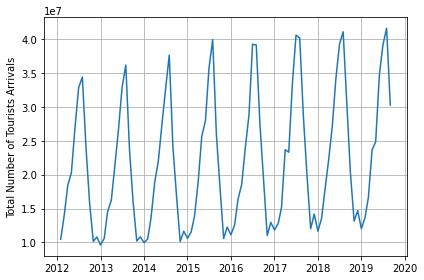

In [28]:
import matplotlib.pylab as plt
plt.plot(ts)
plt.ylabel('Total Number of Tourists Arrivals')
plt.grid()
plt.tight_layout()
plt.savefig('plots/IT_tourists_arrivals.png')
plt.show()

## Calculate the parameters for the model

We build a SARIMA model to represent the time series.
SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. It is composed of two models AR and MA. The model is defined by three parameters:
* d = degree of first differencing involved
* p = order of the AR part
* q = order of the moving average part.

The value of p can be determined through the ACF plot, which shows the autocorrelations which measure the relationship between an observation and its previous one.
The value of d is the order of integration and can be calculated as the number of transformations needed to make the time series stationary.
The value of q can be determined through the PACF plot.

In order determine the value of `d`, we can perform the Dickey-Fuller test, which is able to verify whether a time series is stationary or not. We can use the `adfuller` class, contained in the `statsmodels` library. We define a function, called `test_stationarity()`, which returns True, if the time series is positive, False otherwise.

In [57]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

We transform the time series through the `diff()` function as many times as the time series becomes stationary.

In [58]:
ts_diff = pd.Series(ts)
d = 0
while test_stationarity(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is not stationary
X is stationary


In [60]:
d

1

In order to calculate the value of p and q, we can plot the ACF and PACF graphs, respectively. We can use the `plot_acf()` and `plot_pacf()` functions available in the `statsmodels` library. The value of p corresponds to the maximum value in the ACF graph external to the confidence intervals (shown in light blue). In our case, che correct value of p = 9. Similarly, the value of q corresponds to the maximum value in the PACF graph external to the confidence intervals (shown in light blue). In our case, che correct value of q = 1. 

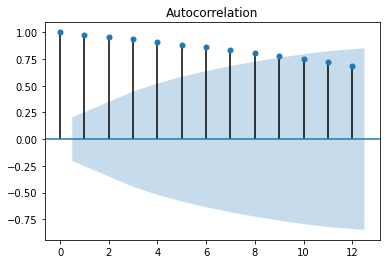

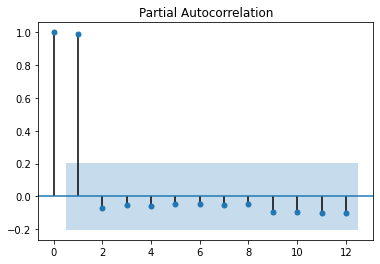

In [71]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_trend, lags =12)
plt.savefig('plots/acf.png')
plt.show()
plot_pacf(ts_trend, lags =12)
plt.savefig('plots/pacf.png')
plt.show()

## Build the SARIMA model
Now we are ready to build the SARIMA model. We can use the `SARIMAX` class provided by the `statsmodels` library. 
We fit the model and get the prediction through the `get_prediction()` function. We can retrieve also the confidence intervals through the `conf_int()` function.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


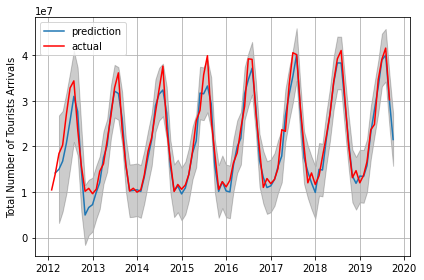

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 9
q = 1
model = SARIMAX(ts, order=(p,d,q))
model_fit = model.fit(disp=1,solver='powell')
    
fcast = model_fit.get_prediction(start=1, end=len(ts))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()


plt.show()
plt.plot(ts_p,label='prediction')
plt.plot(ts,color='red',label='actual')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)

plt.ylabel('Total Number of Tourists Arrivals')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig('plots/IT_trend_prediction.png')
plt.show()

## Calculate some statistics
Finally, we can calculate some statistics to evaluate the performance of the model. We calculate the Pearson's coefficient, through the `pearsonr()` function provided by the `scipy` library, and the R squared metrics.

In [74]:
from scipy import stats
stats.pearsonr(ts_trend_p[1:], ts[1:]) 

(0.8344998287499596, 9.238669708059763e-25)

In [75]:
residuals = ts - ts_trend_p
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ts-np.mean(ts))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.9309287694336666

## Bibliography
* [A Visual Guide to Time Series Decomposition Analysis](https://medium.com/better-programming/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930)
* [An example of time series](https://github.com/arshren/TimeSeries/blob/master/Stock%20Price%20APPL.ipynb)
* [ARIMA Model Python Example — Time Series Forecasting](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
* [ARIMA model to forecast international tourist visit
in Bumthang, Bhutan](https://iopscience.iop.org/article/10.1088/1742-6596/1039/1/012023/pdf)
* [Augmented Dickey-Fuller Test in Python](http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/)
* [Auto ARIMA using Pyramid ARIMA Python Package](https://datafai.com/auto-arima-using-pyramid-arima-python-package/)
* [Confidence Interval for t-test (difference between means) in Python](https://stackoverflow.com/questions/31768464/confidence-interval-for-t-test-difference-between-means-in-python)
* [Extracting Seasonality and Trend from Data: Decomposition Using R](https://anomaly.io/seasonal-trend-decomposition-in-r/index.html)
* [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
* [How can I make a time-series stationary?](https://www.researchgate.net/post/How_can_I_make_a_time-series_stationary)
* [How to Remove Trends and Seasonality with a Difference Transform in Python](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)
* [How to Tune ARIMA Parameters in Python](https://machinelearningmastery.com/tune-arima-parameters-python/)
* [Non-seasonal ARIMA models](https://otexts.com/fpp2/non-seasonal-arima.html)
* [Interpret the partial autocorrelation function (PACF)](https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/)
* [Stationarity testing using the Augmented Dickey-Fuller test](https://medium.com/wwblog/stationarity-testing-using-the-augmented-dickey-fuller-test-8cf7f34f4844)
* [The signal and the noise](http://people.fisica.uniroma2.it/~solare/en/wp-content/uploads/2018/12/Lez_12_Noises.pdf)
* [Time Series Decomposition](http://course1.winona.edu/bdeppa/FIN%20335/Handouts/Time_Series_Decomposition.html#multiplicative-decomposition)
* [Time Series Forecast : A basic introduction using Python.](https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)
* [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
* [Time Series Forecast Case Study with Python: Monthly Armed Robberies in Boston](https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/)
* [Time Series prediction using SARIMAX](https://medium.com/datadriveninvestor/time-series-prediction-using-sarimax-a6604f258c56)
* [Understand ARIMA and tune P, D, Q](https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q)